<a href="https://colab.research.google.com/github/rikurzt/Finacial_analyze_course_HW/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A_HW7_7113029027%E6%9D%8E%E5%86%A0%E5%BB%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 匯入資料

In [ ]:
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt


In [ ]:
def call_twse_api(stock_id=2330, year=2024, month=9):
  """Calls the TWSE API to retrieve stock data for a specific month."""
  url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={year}{month:02}01&stockNo={stock_id}"
  try:
    response = requests.get(url)
    response.raise_for_status()
    return response.json()
  except requests.exceptions.RequestException as e:
    print(f"Error calling API: {e}")
    return None

In [ ]:
def get_stock_data(stock_id, start_year, end_year):
  """Retrieves stock data for a given stock ID within a year range."""
  all_data = []
  for year in range(start_year, end_year + 1):
    for month in range(1, 13):
      data = call_twse_api(stock_id, year, month)
      if data and 'data' in data:
        all_data.extend(data['data'])
  return all_data

In [ ]:
stock_data = get_stock_data('0050', start_year =2020, end_year = 2023)

df = pd.DataFrame(stock_data, columns=['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數'])


In [ ]:
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,109/01/02,"4,882,015","476,649,683",97.05,98.00,97.05,97.65,+0.70,"2,421"
1,109/01/03,"6,813,547","665,657,992",98.30,98.70,97.00,97.65,0.00,"3,080"
2,109/01/06,"9,321,768","901,060,879",97.05,97.10,96.40,96.40,-1.25,"4,809"
3,109/01/07,"6,328,602","607,425,541",96.45,96.70,95.40,96.10,-0.30,"4,116"
4,109/01/08,"8,516,995","813,733,739",95.20,96.20,95.05,95.65,-0.45,"5,033"
...,...,...,...,...,...,...,...,...,...
969,112/12/25,"8,406,012","1,122,521,003",133.00,133.80,132.95,133.50,+0.55,"8,464"
970,112/12/26,"17,326,648","2,325,240,676",133.50,134.40,133.50,134.25,+0.75,"11,845"
971,112/12/27,"30,857,192","4,177,189,577",134.40,135.90,134.35,135.75,+1.50,"16,671"
972,112/12/28,"15,353,146","2,085,248,437",135.75,136.00,135.45,135.75,0.00,"9,803"


In [ ]:
df['開盤價'] = pd.to_numeric(df['開盤價'], errors='coerce')
df['最高價'] = pd.to_numeric(df['最高價'], errors='coerce')
df['最低價'] = pd.to_numeric(df['最低價'], errors='coerce')
df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,109/01/02,"4,882,015","476,649,683",97.05,98.0,97.05,97.65,+0.70,"2,421"
1,109/01/03,"6,813,547","665,657,992",98.30,98.7,97.00,97.65,0.00,"3,080"
2,109/01/06,"9,321,768","901,060,879",97.05,97.1,96.40,96.40,-1.25,"4,809"
3,109/01/07,"6,328,602","607,425,541",96.45,96.7,95.40,96.10,-0.30,"4,116"
4,109/01/08,"8,516,995","813,733,739",95.20,96.2,95.05,95.65,-0.45,"5,033"
...,...,...,...,...,...,...,...,...,...
969,112/12/25,"8,406,012","1,122,521,003",133.00,133.8,132.95,133.50,+0.55,"8,464"
970,112/12/26,"17,326,648","2,325,240,676",133.50,134.4,133.50,134.25,+0.75,"11,845"
971,112/12/27,"30,857,192","4,177,189,577",134.40,135.9,134.35,135.75,+1.50,"16,671"
972,112/12/28,"15,353,146","2,085,248,437",135.75,136.0,135.45,135.75,0.00,"9,803"


# 資料前處理

In [ ]:
import torch
import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
class MyDataSet(data.Dataset):
  def __init__(self,seq_len,train=True,transform=None):#繼承dataset需要transform，Train:使用訓練資料還是測試資料
    df_len = len(df)-1
    df_len -= df_len%seq_len#根據設定序列長度seq_len，扣掉剩下不足的部分
    total_size = df_len // seq_len#現在總共有多少條序列
    train_size = int(total_size * 0.7) #訓練資料使用70%的序列

    f = df.iloc[:(train_size * seq_len),3:7]# iloc:根據index locate到df中指定區塊，train_size * seq_len代表訓練資料會拿到第幾筆，抓到第3~6欄位
    l = df.iloc[1:(train_size * seq_len)+1,6]#用前一天的資料預測，所以從1開始取
    data_size = train_size
    if not train:#使用者要測試資料的情況
      f = df.iloc[train_size * seq_len:df_len,3:7]#從訓練資料結尾開始
      l = df.iloc[(train_size * seq_len)+1:df_len+1,6]
      data_size = total_size - train_size

    self.features = np.array(f).astype("float32").reshape(data_size,seq_len,4)
    self.labels = np.array(l).astype("float32").reshape(data_size,seq_len,1)
    self.transform = transform
  def __len__(self):#取得目前處理的資料長度
    return len(self.labels)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    x = self.features[idx]
    y = self.labels[idx]
    if self.transform:
      x = self.transform(x)
      y = self.transform(y)
    return x,y

In [ ]:
def toTensor(x):
  return torch.tensor(x)

In [ ]:
train_dataset = MyDataSet(seq_len=5,train=True,transform=toTensor)
test_dataset = MyDataSet(seq_len=5,train=False,transform=toTensor)

In [ ]:
feature,labels = train_dataset[2:9]
print(feature.shape)
print(labels.shape)
feature

torch.Size([7, 5, 4])
torch.Size([7, 5, 1])


tensor([[[97.1500, 97.5000, 97.0000, 97.3000],
         [97.7000, 97.7500, 97.1000, 97.3000],
         [97.5500, 98.0000, 97.5500, 97.7000],
         [95.0000, 95.0000, 92.1500, 92.1500],
         [90.6500, 90.6500, 89.6500, 89.9500]],

        [[88.5000, 89.1500, 87.6000, 89.0500],
         [89.4500, 90.9500, 89.2000, 90.6000],
         [91.0000, 91.3000, 90.3000, 90.8500],
         [91.6500, 92.3000, 91.3500, 92.3000],
         [91.6500, 91.6500, 90.9500, 91.2000]],

        [[90.0000, 91.2000, 89.6000, 91.0000],
         [91.3500, 91.9500, 91.3500, 91.7500],
         [92.0000, 92.9000, 92.0000, 92.6500],
         [93.0000, 93.2500, 92.7000, 92.8000],
         [92.8000, 93.2500, 92.5500, 92.9500]],

        [[92.3000, 92.5500, 91.9500, 92.3000],
         [91.4000, 91.6000, 91.0000, 91.0500],
         [91.1500, 92.2500, 91.0500, 92.1000],
         [92.3500, 92.5000, 91.3500, 91.7000],
         [91.6500, 91.9500, 90.9500, 91.2500]],

        [[90.2500, 90.4000, 89.7000, 90.1000],
     

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=5,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=5,shuffle=False)

In [ ]:
for i,(seqs,labels) in enumerate(train_loader):
  print(seqs.shape)
seqs

torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])
torch.Size([5, 5, 4])


tensor([[[115.5000, 115.6000, 114.7500, 115.1500],
         [115.1000, 115.1000, 113.8500, 113.9000],
         [114.1000, 114.7500, 113.7000, 114.1500],
         [114.8000, 115.4000, 114.2500, 114.9000],
         [113.1000, 113.1500, 112.1000, 112.2000]],

        [[113.0500, 113.0500, 112.4000, 113.0000],
         [115.3000, 115.6500, 115.0000, 115.4000],
         [116.1000, 116.4000, 115.7500, 116.0000],
         [113.0500, 113.9500, 112.8000, 113.6500],
         [113.5000, 114.2500, 113.2000, 113.8500]],

        [[112.6500, 112.8500, 112.3000, 112.5500],
         [112.9500, 112.9500, 111.9000, 112.0500],
         [112.5500, 113.1500, 112.2500, 113.0500],
         [112.8000, 112.8000, 111.8000, 112.1000],
         [110.4000, 110.7500, 109.5000, 110.7500]],

        [[110.2500, 110.3500, 109.3500, 109.7000],
         [108.0500, 108.0500, 107.1500, 107.6500],
         [107.8000, 107.9500, 107.0000, 107.5000],
         [107.6000, 107.6500, 105.2500, 105.2500],
         [106.4500, 106.4

# ANN

In [ ]:
import torch.nn as nn

In [ ]:
input_size = 4
output_size = 1
hidden_size = 64
num_epochs = 5
batch_size = 5
learning_rate = 0.001

In [ ]:
class ANN(torch.nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(ANN,self).__init__()
    self.normal = nn.BatchNorm1d(5,affine=True)
    self.fc1 = torch.nn.Linear(input_size,hidden_size,bias=False)
    self.ReLU = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(hidden_size,hidden_size//2,bias=False)
    self.ReLU = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(hidden_size//2,output_size,bias=False)

  def forward(self,x):

    x = self.normal(x)
    x = self.fc1(x)
    x = self.ReLU(x)
    x = self.fc2(x)
    x = self.ReLU(x)
    x = self.fc3(x)
    return x

## Trainning

In [ ]:
import torch.optim as optim

In [ ]:

model = ANN(input_size,hidden_size,output_size)


loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 12000
for epoch in range(epochs):
  model.train()
  for seqs, labels in train_loader:
      outputs = model(seqs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  if (epoch+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/12000], Loss: 29.7470
Epoch [200/12000], Loss: 29.2416
Epoch [300/12000], Loss: 27.8047
Epoch [400/12000], Loss: 25.8470
Epoch [500/12000], Loss: 26.4027
Epoch [600/12000], Loss: 22.7371
Epoch [700/12000], Loss: 18.3334
Epoch [800/12000], Loss: 18.5013
Epoch [900/12000], Loss: 19.4138
Epoch [1000/12000], Loss: 14.0157
Epoch [1100/12000], Loss: 14.2784
Epoch [1200/12000], Loss: 13.5881
Epoch [1300/12000], Loss: 13.4193
Epoch [1400/12000], Loss: 13.5724
Epoch [1500/12000], Loss: 13.6541
Epoch [1600/12000], Loss: 13.7343
Epoch [1700/12000], Loss: 13.9053
Epoch [1800/12000], Loss: 13.7816
Epoch [1900/12000], Loss: 13.8251
Epoch [2000/12000], Loss: 13.7691
Epoch [2100/12000], Loss: 13.7003
Epoch [2200/12000], Loss: 13.7942
Epoch [2300/12000], Loss: 13.8108
Epoch [2400/12000], Loss: 13.7944
Epoch [2500/12000], Loss: 13.7165
Epoch [2600/12000], Loss: 13.7014
Epoch [2700/12000], Loss: 13.6477
Epoch [2800/12000], Loss: 13.4868
Epoch [2900/12000], Loss: 13.5752
Epoch [3000/12000], Los

In [ ]:
#test
model.eval()
all_test_outputs = []
with torch.no_grad():
  for seqs, labels in test_loader:
    outputs = model(seqs)
    all_test_outputs.append(outputs.view(-1))
    loss = loss_fn(outputs, labels)

    print(f'Test Loss: {loss.item():.4f}')

Test Loss: 42.3970
Test Loss: 18.3954
Test Loss: 22.1119
Test Loss: 13.2133
Test Loss: 13.1197
Test Loss: 14.7442
Test Loss: 3.4693
Test Loss: 3.9010
Test Loss: 4.1805
Test Loss: 5.9367
Test Loss: 5.6653
Test Loss: 5.3620


In [ ]:
#Flatten all_test_outputs
flattened_test_outputs = torch.cat([tensor.view(1) if tensor.dim() == 0 else tensor for tensor in all_test_outputs], dim=0)

flattened_test_outputs.size()


torch.Size([295])

In [ ]:
(len(df)-1)*0.3

291.9

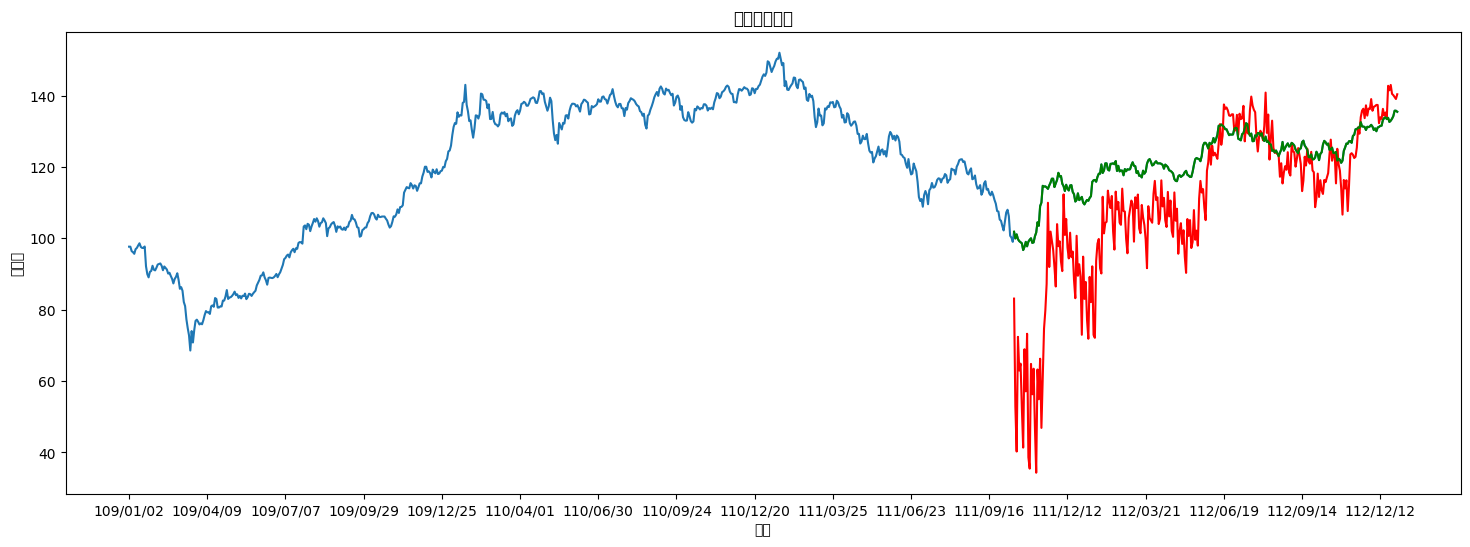

In [ ]:
df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')
plt.figure(figsize=(18, 6))
plt.plot(df['日期'], df['收盤價'])
plt.xlabel('日期')
plt.ylabel('收盤價')
plt.title('收盤價走勢圖')

plt.xticks(df.get('日期')[::60],rotation=0)




plt.plot(df['日期'][len(df)-295:], all_test_outputs, color='red')
plt.plot(df['日期'][len(df)-295:], df['收盤價'][len(df)-295:], color='green')
plt.show()

plt.show()

# CNN

In [ ]:
stock_data = get_stock_data('0050', start_year =2016, end_year = 2024)

df = pd.DataFrame(stock_data, columns=['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數'])


## 計算技術指標（SMA、RSI、MACD）

In [ ]:
!pip install pandas_ta

In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta

In [ ]:
def calculate_sma(data, window):

  return ta.sma(data['收盤價'], length=window)

def calculate_rsi(data, window):
  return ta.rsi(data['收盤價'], length=window)

def calculate_macd(data, short_window, long_window, signal_window):
  try:
      macd_df = ta.macd(data['收盤價'], fast=short_window, slow=long_window, signal=signal_window)
      return macd_df['MACD_12_26_9'], macd_df['MACDh_12_26_9'], macd_df['MACDs_12_26_9']
  except (KeyError, TypeError):
    return None, None, None

def calculate_ema(data, window):
  return ta.ema(data['收盤價'], length=window)


# 繪製K線圖

In [ ]:
# prompt: #計算KD

def calculate_kd(df, n=9):
  df['最高價'] = pd.to_numeric(df['最高價'])
  df['最低價'] = pd.to_numeric(df['最低價'])
  df['收盤價'] = pd.to_numeric(df['收盤價'])

  df['RSV'] = ((df['收盤價'] - df['最低價'].rolling(n).min()) /
              (df['最高價'].rolling(n).max() - df['最低價'].rolling(n).min())) * 100
  df['K'] = 50
  df['D'] = 50

  for i in range(n, len(df)):
      df['K'].iloc[i] = (df['K'].iloc[i - 1] * 2 / 3) + (df['RSV'].iloc[i] * 1 / 3)
      df['D'].iloc[i] = (df['D'].iloc[i - 1] * 2 / 3) + (df['K'].iloc[i] * 1 / 3)



In [ ]:
!pip install mpl_finance

In [ ]:
import pandas as pd
import mpl_finance as mpf
import matplotlib.pyplot as plt
import matplotlib

In [ ]:

!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib


matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-10-28 16:13:07--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.23.113, 74.125.23.139, 74.125.23.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.23.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-28 16:13:08--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.23.132, 2404:6800:4008:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.23.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  44.3MB/s    in 0.4s    

2024-10-28 16:13:14 (44

In [ ]:
calculate_kd(df)

<ipython-input-56-38931eb49cc6>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['K'].iloc[i] = (df['K'].iloc[i - 1] * 2 / 3) + (df['RSV'].iloc[i] * 1 / 3)
<ipython-input-56-38931eb49cc6>:14: SettingWithCopyWarning: 
A value is trying to

In [ ]:
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,RSV,K,D
0,105/01/04,"16,928,063","1,009,176,452",60.80,60.95,59.05,59.55,-1.20,"5,730",NaN,50.000000,50.000000
1,105/01/05,"21,783,969","1,291,792,220",59.50,59.75,58.85,59.05,-0.50,"6,708",NaN,50.000000,50.000000
2,105/01/06,"28,939,550","1,688,039,896",59.05,59.05,57.90,58.45,-0.60,"8,406",NaN,50.000000,50.000000
3,105/01/07,"39,962,301","2,289,801,488",58.30,58.30,56.70,57.35,-1.10,"11,325",NaN,50.000000,50.000000
4,105/01/08,"25,450,734","1,459,152,633",57.00,57.70,56.85,57.45,+0.10,"7,024",NaN,50.000000,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2145,113/10/22,"8,995,727","1,768,962,781",197.20,197.30,195.35,197.30,-0.75,"14,274",74.107143,79.984303,80.330703
2146,113/10/23,"10,050,673","1,970,225,174",196.70,196.90,195.65,196.00,-1.30,"16,526",62.331839,74.100148,78.253851
2147,113/10/24,"8,642,395","1,691,119,396",196.00,196.70,194.50,194.80,-1.20,"13,537",41.621622,63.273973,73.260558
2148,113/10/25,"12,961,246","2,539,355,383",195.00,196.55,195.00,196.40,+1.60,"14,768",55.555556,60.701167,69.074095


In [ ]:

df['開盤價'] = pd.to_numeric(df['開盤價'], errors='coerce')
df['最高價'] = pd.to_numeric(df['最高價'], errors='coerce')
df['最低價'] = pd.to_numeric(df['最低價'], errors='coerce')
df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')


# 設定每 30 天輸出一張圖
window_size = 30

for i in range(0, len(df), window_size):
    # 取出當前 30 天的數據
    df_slice = df.iloc[i:i + window_size]

    # 當數據少於 30 天時跳出迴圈
    if len(df_slice) < window_size:
        break

    # 創建圖表
    fig = plt.figure(figsize=(4, 4),dpi=100)
    ax = fig.add_axes([1, 0.5, 1, 1])


    # 設定 x 軸的日期顯示
    ax.set_xticks(range(0, len(df_slice.index), 5))  # 每隔 5 天顯示一次
    ax.set_xticklabels(df_slice["日期"].iloc[::5])

    # 繪製 K 線圖
    mpf.candlestick2_ochl(ax, df_slice['開盤價'], df_slice['收盤價'], df_slice['最高價'],
                          df_slice['最低價'], width=0.6, colorup='r', colordown='g', alpha=0.75)

    # 繪製 5 日和 10 日均線
    ax.plot(df_slice['日期'], calculate_sma(df_slice, 5), label='SMA_5')
    ax.plot(df_slice['日期'], calculate_sma(df_slice, 10), label='SMA_10')

    # 設置圖例
    fig.tight_layout()


    #檢查五日線是否穿過十日線，下穿上label就是1
    # 計算 5 日和 10 日均線
    sma_5 = calculate_sma(df_slice, 5)
    sma_10 = calculate_sma(df_slice, 10)

    # 初始化標籤
    label = 0  # 預設為 0 表示沒有「下穿」

    # 檢查 10、20、30 天的均線關係並設定標籤
    label_points = [10, 20, 30]  # 檢查的特定點
    label = 1  # 預設為「漲」

    for point in label_points:
        if point < len(df_slice):
            # 檢查每個點，如果有任一點 5 日均線低於或等於 10 日均線，標記為「跌」
            if sma_5.iloc[point] <= sma_10.iloc[point]:
                label = 0
                break



    # 顯示圖表
    fig = plt.gcf()
    fig.savefig(f'chart/k_line_{i // window_size}_{label}.png',bbox_inches='tight',dpi=100)
    plt.close(fig)



<ipython-input-87-c881b127eafe>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [ ]:
label

1

In [ ]:

import pandas as pd
import os
import cv2

def load_images(directory):
  dataset = pd.DataFrame(columns=['data','targets'])
  for filename in os.listdir(directory):
    name = "k_line_"
    if filename.startswith(name) and filename.endswith(".png"):
      filepath = os.path.join(directory, filename)
      image = cv2.imread(filepath)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (400, 400))


      label = int(filename.split("_")[-1].split(".")[0])
      dataset.loc[len(dataset)] = [image, label]
  return dataset



image_directory = "/content/chart"
dataset= load_images(image_directory)



0


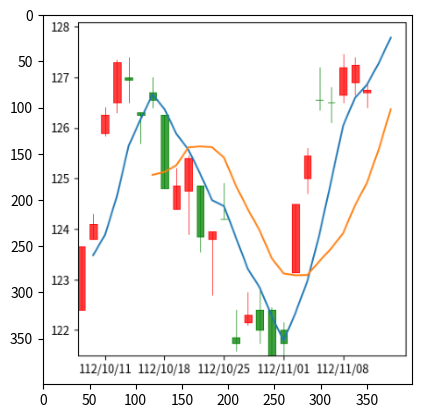

In [ ]:
plt.imshow(dataset['data'][50])
print(dataset['targets'][50])

In [ ]:
from torch.utils.data import Dataset

In [ ]:


class PdDataset(Dataset):

    # data loading
    def __init__(self,dataframe):
        self.x = dataframe['data']
        self.y = dataframe['targets']
        self.n_samples = len(self.x)

    # working for indexing
    def __getitem__(self, index):

        return self.x[index], self.y[index]

    # return the length of our dataset
    def __len__(self):

        return self.n_samples

In [ ]:
dataset = PdDataset(dataset)

In [ ]:
dataset[4]

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [ ]:
import torch


In [ ]:
#分割資料
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1 ,shuffle=False)

In [ ]:
len(train_dataset)

56

In [ ]:
for images,labels in  test_loader:
  print(images.shape)
  break

torch.Size([1, 400, 400, 3])


## CNN model

In [ ]:

import torch.nn as nn

class Model(nn.Module):


  def __init__(self, num_classes=1):
    super(Model, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4, 4)),

        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4, 4))
    )


    self.dense = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25*25*64, 1024),
        nn.ReLU(),
        nn.Linear(1024, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes),
        nn.Sigmoid()

    )

  def forward(self, x):
    out = self.conv(x)
    out = self.dense(out)
    return out

In [ ]:
model = Model()
if torch.cuda.is_available():
  print("CUDA available")
  model.cuda()#把模型移到GPU

CUDA available


## Train

In [ ]:
num_epochs = 1000
batch_size = 1
learning_rate = 0.001

In [ ]:
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = Variable(torch.as_tensor(images).type(torch.cuda.FloatTensor)) if torch.cuda.is_available() else Variable(torch.as_tensor(images).type(torch.float32))
        labels = Variable(torch.as_tensor(labels).type(torch.cuda.FloatTensor)) if torch.cuda.is_available() else Variable(torch.as_tensor(labels).type(torch.float32))

        optimizer.zero_grad()
        #把表示channel的dimention從最後一個維度換到第二個維度
        images = images.permute(0, 3, 1, 2)
        outputs = model(images)

        loss = loss_fn(outputs.reshape(-1),labels)
        loss.backward()
        optimizer.step()
    if  epoch%10 == 0:
      print('Epoch :{}, Batch:{}, Loss: {:.4f}'.format(epoch+1,i+1,loss.data))

Epoch :1, Batch:56, Loss: 0.1996
Epoch :11, Batch:56, Loss: 1.4575
Epoch :21, Batch:56, Loss: 0.6861
Epoch :31, Batch:56, Loss: 0.5201
Epoch :41, Batch:56, Loss: 0.2294
Epoch :51, Batch:56, Loss: 0.2654
Epoch :61, Batch:56, Loss: 1.1043
Epoch :71, Batch:56, Loss: 1.0474
Epoch :81, Batch:56, Loss: 0.8031
Epoch :91, Batch:56, Loss: 1.1043
Epoch :101, Batch:56, Loss: 0.2294
Epoch :111, Batch:56, Loss: 0.3688
Epoch :121, Batch:56, Loss: 1.0876
Epoch :131, Batch:56, Loss: 0.4145
Epoch :141, Batch:56, Loss: 1.0145
Epoch :151, Batch:56, Loss: 0.4485
Epoch :161, Batch:56, Loss: 1.3405
Epoch :171, Batch:56, Loss: 0.3667
Epoch :181, Batch:56, Loss: 0.6376
Epoch :191, Batch:56, Loss: 1.2723
Epoch :201, Batch:56, Loss: 0.6805
Epoch :211, Batch:56, Loss: 0.2238
Epoch :221, Batch:56, Loss: 1.3405
Epoch :231, Batch:56, Loss: 0.6161
Epoch :241, Batch:56, Loss: 0.2294
Epoch :251, Batch:56, Loss: 0.2815
Epoch :261, Batch:56, Loss: 0.7412
Epoch :271, Batch:56, Loss: 0.2815
Epoch :281, Batch:56, Loss: 1.0

放入測試資料看結果

In [ ]:
import torch

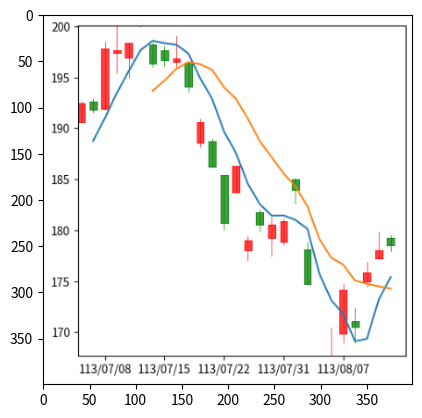

labels:跌
outputs:跌


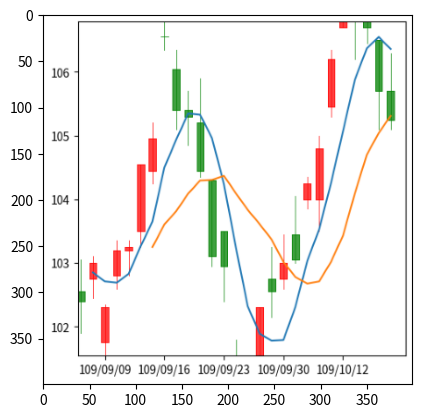

labels:跌
outputs:漲


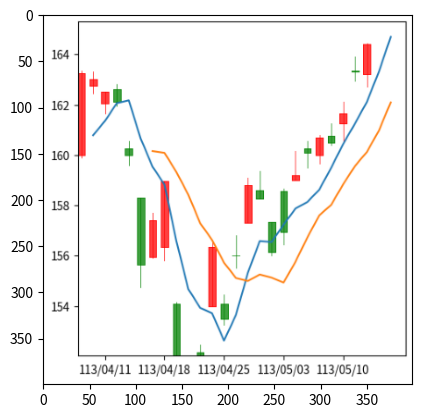

labels:跌
outputs:漲


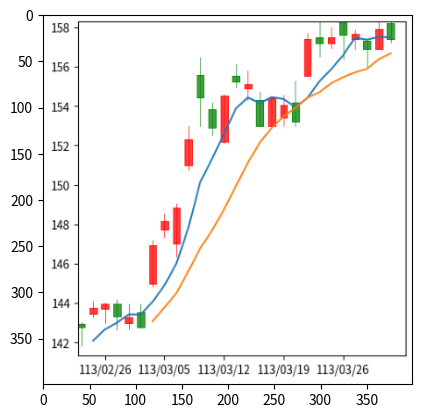

labels:漲
outputs:漲


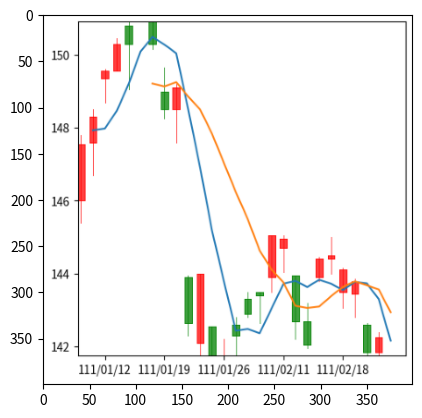

labels:跌
outputs:漲


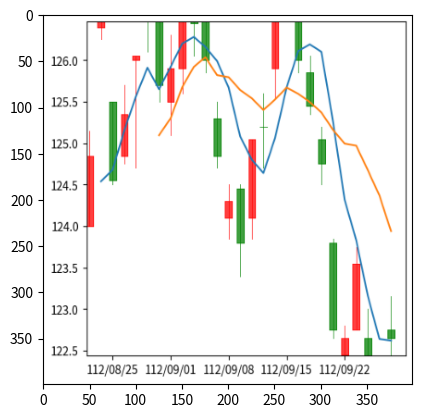

labels:跌
outputs:跌


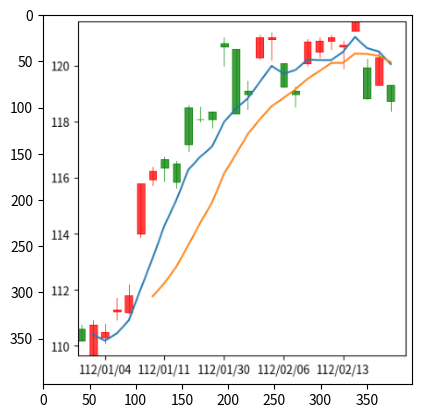

labels:漲
outputs:跌


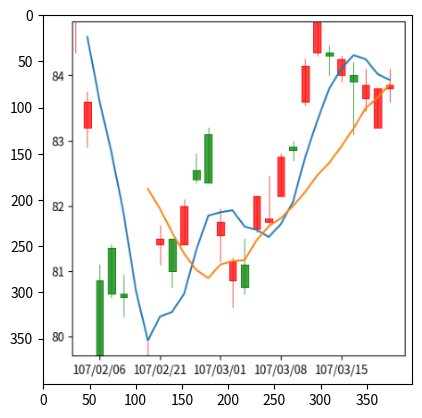

labels:跌
outputs:漲


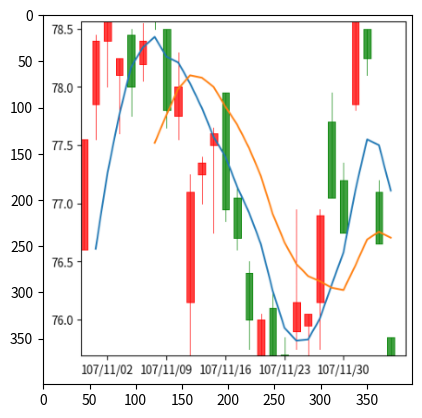

labels:跌
outputs:跌


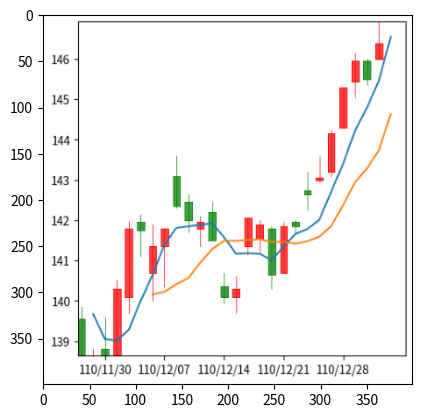

labels:跌
outputs:跌


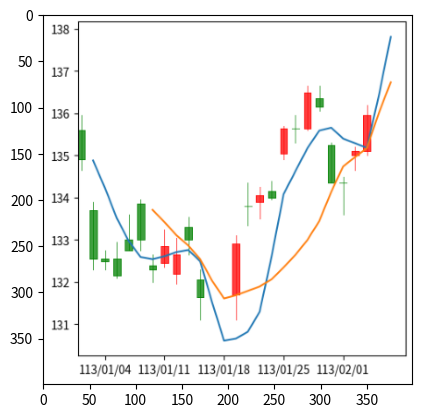

labels:跌
outputs:跌


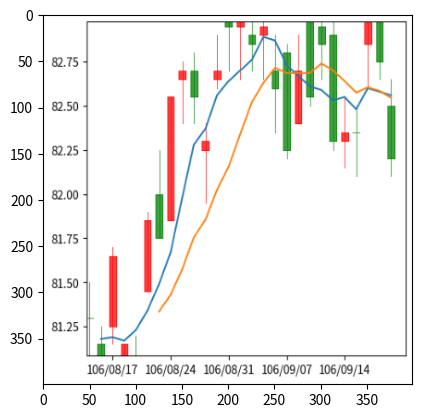

labels:漲
outputs:漲


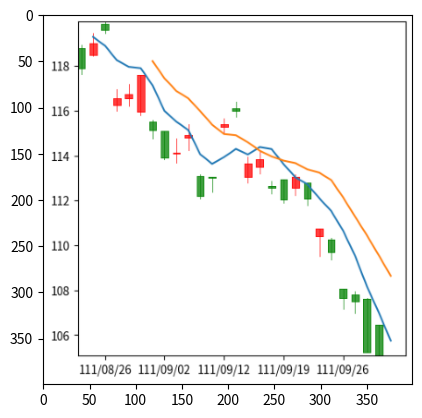

labels:跌
outputs:跌


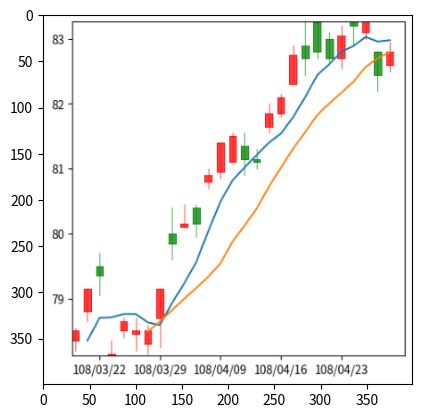

labels:跌
outputs:跌


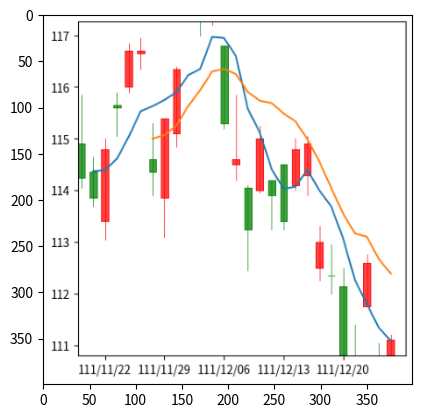

labels:跌
outputs:跌
Accuracy : 66.667%


In [ ]:
correct = 0
total = 0
for images, labels in test_loader:#只要算正確率就不用編號了
    image = images.type(torch.cuda.FloatTensor) if torch.cuda.is_available() else images.type(torch.float32)
    image = image.permute(0, 3, 1, 2)

    outputs = model(image)#現在丟進classfier，應該會得到一個所有標籤機率的陣列

    #show image and labels and outputs
    plt.imshow(images[0])
    plt.show()
    print("labels:漲" if labels[0]==1 else "labels:跌")
    print("outputs:漲" if outputs[0]>0.5 else "outputs:跌")


    #大於0.5就變1，小於就變0
    outputs = 1 if outputs[0]>0.5 else 0
    #計算正確次數
    correct += (outputs==labels).sum()#累加正確次數(與標籤值相等)
    total += labels.size(0)
print('Accuracy : {:.3f}%'.format(100*correct/float(total)))